# MODEL

In [68]:
# ================================================
# 1) Imports
# ================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

plt.style.use('seaborn')
pd.set_option('display.max_columns', None)


/tmp/ipykernel_16219/806087732.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [69]:
filename = 'Ndata.csv'
data = pd.read_csv(filename)
data.rename(columns={data.columns[0]: "id"}, inplace=True) 
pd.set_option('display.max_columns', None) # To show all columns
data.sample(3)

,id,ALT,HDL,Cholesterol,weight(kg),LDL,age,hearing(left),waist(cm),hemoglobin,height(cm),smoking
49237,49237,10,53,206,50,135,50,1,70.0,13.7,155,0
115817,115817,15,73,164,60,73,40,1,72.0,12.5,165,0
75344,75344,31,39,161,70,93,25,1,83.0,14.6,170,0


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             159256 non-null  int64  
 1   ALT            159256 non-null  int64  
 2   HDL            159256 non-null  int64  
 3   Cholesterol    159256 non-null  int64  
 4   weight(kg)     159256 non-null  int64  
 5   LDL            159256 non-null  int64  
 6   age            159256 non-null  int64  
 7   hearing(left)  159256 non-null  int64  
 8   waist(cm)      159256 non-null  float64
 9   hemoglobin     159256 non-null  float64
 10  height(cm)     159256 non-null  int64  
 11  smoking        159256 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 14.6 MB


In [71]:
data.isna().sum()

id               0
ALT              0
HDL              0
Cholesterol      0
weight(kg)       0
LDL              0
age              0
hearing(left)    0
waist(cm)        0
hemoglobin       0
height(cm)       0
smoking          0
dtype: int64

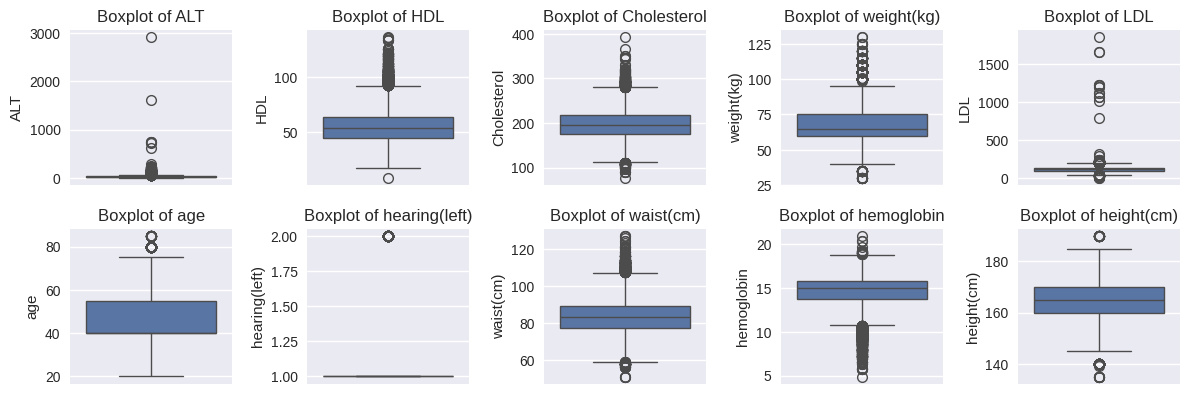

In [72]:
numerical_cols = ['ALT', 'HDL', 'Cholesterol', 'weight(kg)', 'LDL', 'age', 'hearing(left)', 'waist(cm)', 'hemoglobin', 'height(cm)']
# [
#     'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'systolic', 
#     'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 
#     'HDL','hemoglobin'
# ]

plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 5, i)  
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

In [73]:
for col in data.select_dtypes(include=[np.number]).columns:
    if col =='dental caries':
        continue
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.8 * IQR
    lower_bound = Q1 - 1.5 * IQR
    outliers_below = data[data[col] < lower_bound].shape[0]
    outliers_above = data[data[col] > upper_bound].shape[0]
    if outliers_below + outliers_above > 500:
        # handle values above the upper bound
        data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
        # handle values below the lower bound
        data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    else :
        upper_bound = Q3 + 1.6 * IQR
        lower_bound = Q1 - IQR
        data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
        data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])

In [74]:
data.describe()

,id,ALT,HDL,Cholesterol,weight(kg),LDL,age,hearing(left),waist(cm),hemoglobin,height(cm),smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.0,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,25.923458,55.826788,195.835558,67.113562,114.546457,44.421366,1.0,83.034845,14.807563,165.378290,0.437365
std,45973.391572,12.916673,13.872204,28.163075,12.483615,25.761897,11.601336,0.0,8.822533,1.393455,8.577791,0.496063
min,0.000000,1.000000,16.500000,133.000000,37.500000,57.000000,25.000000,1.0,65.000000,10.800000,150.000000,0.000000
25%,39813.750000,16.000000,45.000000,175.000000,60.000000,95.000000,40.000000,1.0,77.000000,13.800000,160.000000,0.000000
50%,79627.500000,22.000000,54.000000,196.000000,65.000000,114.000000,40.000000,1.0,83.000000,15.000000,165.000000,0.000000
75%,119441.250000,32.000000,64.000000,217.000000,75.000000,133.000000,55.000000,1.0,89.000000,15.800000,170.000000,1.000000
max,159255.000000,60.800000,98.200000,284.200000,102.000000,193.800000,79.000000,1.0,108.200000,19.400000,186.000000,1.000000


In [75]:

X = data.drop(['id', 'smoking'], axis=1)
y = data['smoking']  
print("Features shape:", X.shape)
print("Target shape:", y.shape)




Features shape: (159256, 10)
Target shape: (159256,)


In [76]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,   
    random_state=42,
    stratify=y       
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,   
    random_state=42,
    stratify=y_temp  
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (95553, 10) (95553,)
Validation shape: (31851, 10) (31851,)
Test shape: (31852, 10) (31852,)


In [77]:

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)

print(" Logistic Regression Model")
print("Accuracy:", acc_lr)
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


 Logistic Regression Model
Accuracy: 0.7263594122818033
Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.73      0.75     17921
         1.0       0.68      0.72      0.70     13931

    accuracy                           0.73     31852
   macro avg       0.72      0.73      0.72     31852
weighted avg       0.73      0.73      0.73     31852



In [78]:

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print(" Decision Tree ")
print("Accuracy:", acc_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))


 Decision Tree 
Accuracy: 0.6690945623508728
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.71      0.71     17921
         1.0       0.62      0.62      0.62     13931

    accuracy                           0.67     31852
   macro avg       0.66      0.66      0.66     31852
weighted avg       0.67      0.67      0.67     31852



In [79]:

def bagging_from_scratch(X_train, y_train, X_test, n_estimators=10, max_samples_ratio=0.8, random_state=42):
    np.random.seed(random_state)
    n_samples = X_train.shape[0]
    max_samples = int(max_samples_ratio * n_samples)
    
    X_train_np = X_train.values
    y_train_np = y_train.values
    
    estimators = []
    
    for i in range(n_estimators):
        indices = np.random.choice(n_samples, size=max_samples, replace=True)
        X_bootstrap = X_train_np[indices]
        y_bootstrap = y_train_np[indices]
        
        tree = DecisionTreeClassifier(random_state=random_state + i)
        tree.fit(X_bootstrap, y_bootstrap)
        estimators.append(tree)
    
 
    preds = []
    for tree in estimators:
        p = tree.predict(X_test)
        preds.append(p)
    
    preds = np.array(preds).T  
    
    final_predictions = []
    for row in preds:
        vals, counts = np.unique(row, return_counts=True)
        majority_vote = vals[np.argmax(counts)]
        final_predictions.append(majority_vote)
    
    return np.array(final_predictions)


y_pred_bag = bagging_from_scratch(X_train, y_train, X_test, n_estimators=50, max_samples_ratio=0.8, random_state=42)
acc_bag = accuracy_score(y_test, y_pred_bag)

print("=== Bagging (from scratch) ===")
print("Accuracy:", acc_bag)
print("Classification Report:\n", classification_report(y_test, y_pred_bag))


/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-

=== Bagging (from scratch) ===
Accuracy: 0.7373163380635439
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.72      0.75     17921
         1.0       0.68      0.76      0.72     13931

    accuracy                           0.74     31852
   macro avg       0.74      0.74      0.74     31852
weighted avg       0.74      0.74      0.74     31852



In [80]:
# ================================================
# AdaBoost (From Scratch) in a Single Jupyter Cell
# ================================================

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# -------------------------------
# AdaBoost from Scratch
# -------------------------------
def adaboost_from_scratch(X_train, y_train, X_test, n_estimators=10, random_state=42):
    """
    Simple AdaBoost implementation from scratch using Decision Tree stumps (max_depth=1).
    Returns predictions for X_test.

    Parameters:
    -----------
    X_train : pd.DataFrame or np.ndarray
        Training features.
    y_train : pd.Series or np.ndarray
        Training labels (assumed binary: 0/1).
    X_test  : pd.DataFrame or np.ndarray
        Test features on which we want predictions.
    n_estimators : int
        Number of weak learners (stumps) to train.
    random_state : int
        Seed for reproducibility.

    Returns:
    --------
    final_preds : np.ndarray
        Predicted labels (0 or 1) for X_test.
    """
    np.random.seed(random_state)
    
    # Convert data to numpy arrays if needed
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(y_train, pd.Series):
        y_train = y_train.values
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values

    n_samples = X_train.shape[0]
    
    # Initialize sample weights equally
    w = np.ones(n_samples) / n_samples
    
    # Store the stump classifiers and their alpha weights
    learners = []
    alphas = []

    for i in range(n_estimators):
        # Train a stump (max_depth=1)
        stump = DecisionTreeClassifier(max_depth=1, random_state=random_state + i)
        stump.fit(X_train, y_train, sample_weight=w)

        # Predictions on training data
        y_pred = stump.predict(X_train)

        # Compute weighted error
        misclassified = (y_pred != y_train)
        err = np.sum(w * misclassified)

        # Avoid division by zero
        err = max(err, 1e-10)

        # Compute alpha
        alpha = 0.5 * np.log((1 - err) / err)
        
        # Store this weak learner and its weight
        learners.append(stump)
        alphas.append(alpha)

        # Update sample weights
        w = w * np.exp(alpha * misclassified)
        w = w / np.sum(w)  # normalize

    # Inference on X_test
    final_scores = np.zeros(X_test.shape[0])

    for alpha, stump in zip(alphas, learners):
        preds = stump.predict(X_test)
        # Convert 0/1 to +1/-1 for easier accumulation
        preds_binary = np.where(preds == 1, 1, -1)
        final_scores += alpha * preds_binary

    # Convert back to 0/1
    final_preds = np.where(final_scores >= 0, 1, 0)
    return final_preds

# ============================
# Demonstration with Iris Data
# ===========================

In [81]:
y_pred_bag = adaboost_from_scratch(X_train, y_train, X_test)
acc_bag = accuracy_score(y_test, y_pred_bag)

print("=== AdaBoost (from scratch) ===")
print("Accuracy:", acc_bag)
print("Classification Report:\n", classification_report(y_test, y_pred_bag))



=== AdaBoost (from scratch) ===
Accuracy: 0.7166582946125832
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.64      0.72     17921
         1.0       0.64      0.82      0.72     13931

    accuracy                           0.72     31852
   macro avg       0.73      0.73      0.72     31852
weighted avg       0.74      0.72      0.72     31852



In [82]:
# ================================================
# Random Forest (From Scratch) - Single Jupyter Cell
# ================================================

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def random_forest_from_scratch(
    X_train, 
    y_train, 
    X_test, 
    n_estimators=10, 
    max_samples_ratio=0.8, 
    max_features_ratio=0.8, 
    random_state=42
):
    """
    A rudimentary Random Forest from scratch.

    For each of the n_estimators:
      - Draw a bootstrap sample (with replacement) of size = max_samples_ratio * n_samples.
      - Randomly select a subset of features (size = max_features_ratio * total_features).
      - Train a Decision Tree on (bootstrap_sample_rows, random_subset_of_features).
    At prediction time, use majority vote across all trees.
    
    Parameters:
    -----------
    X_train: pd.DataFrame or np.ndarray
        Training features.
    y_train: pd.Series or np.ndarray
        Training labels (assumed binary: 0 or 1).
    X_test : pd.DataFrame or np.ndarray
        Test features on which we want predictions.
    n_estimators : int
        Number of decision trees in the forest.
    max_samples_ratio : float
        Fraction of the training set used for bootstrap sampling.
    max_features_ratio : float
        Fraction of features used for each tree.
    random_state : int
        Seed for reproducibility.

    Returns:
    --------
    final_predictions : np.ndarray
        Predicted labels (0 or 1) for X_test.
    """
    np.random.seed(random_state)
    
    # Convert to numpy if needed
    if isinstance(X_train, pd.DataFrame):
        X_train_np = X_train.values
    else:
        X_train_np = X_train
    
    if isinstance(y_train, pd.Series):
        y_train_np = y_train.values
    else:
        y_train_np = y_train
    
    if isinstance(X_test, pd.DataFrame):
        X_test_np = X_test.values
    else:
        X_test_np = X_test
    
    n_samples = X_train_np.shape[0]
    n_features = X_train_np.shape[1]
    
    max_samples = int(max_samples_ratio * n_samples)
    max_features = int(max_features_ratio * n_features)
    
    estimators = []
    feature_subsets = []
    
    # Train n_estimators decision trees
    for i in range(n_estimators):
        # 1) Bootstrap sampling of rows
        row_indices = np.random.choice(n_samples, size=max_samples, replace=True)
        X_bootstrap = X_train_np[row_indices]
        y_bootstrap = y_train_np[row_indices]
        
        # 2) Random subset of columns (features)
        feature_indices = np.random.choice(n_features, size=max_features, replace=False)
        feature_subsets.append(feature_indices)
        
        # 3) Train a Decision Tree on the (bootstrapped rows, subset of features)
        tree = DecisionTreeClassifier(random_state=random_state + i)
        tree.fit(X_bootstrap[:, feature_indices], y_bootstrap)
        estimators.append(tree)
    
    # --------------------------
    # Inference (Majority Vote)
    # --------------------------
    all_preds = []
    for i, tree in enumerate(estimators):
        preds = tree.predict(X_test_np[:, feature_subsets[i]])
        all_preds.append(preds)

    all_preds = np.array(all_preds).T  # shape (#samples_test, n_estimators)
    
    final_predictions = []
    for row in all_preds:
        vals, counts = np.unique(row, return_counts=True)
        majority_vote = vals[np.argmax(counts)]
        final_predictions.append(majority_vote)
    
    return np.array(final_predictions)

# ============================
# USE ON YOUR OWN DATASET
# ============================


In [83]:
# Assuming you've already defined the function:
# def random_forest_from_scratch(X_train, y_train, X_test, n_estimators=10, ...):

# Call the random_forest_from_scratch function, similar to your AdaBoost usage
y_pred_rf = random_forest_from_scratch(
    X_train, 
    y_train, 
    X_test,
    n_estimators=10,         # number of trees
    max_samples_ratio=0.8,   # fraction of training data in each bootstrap
    max_features_ratio=0.8,  # fraction of features for each tree
    random_state=42
)

# Evaluate
acc_rf = accuracy_score(y_test, y_pred_rf)

print("=== Random Forest (from scratch) ===")
print("Accuracy:", acc_rf)
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


=== Random Forest (from scratch) ===
Accuracy: 0.7077106618108753
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.75      0.74     17921
         1.0       0.67      0.65      0.66     13931

    accuracy                           0.71     31852
   macro avg       0.70      0.70      0.70     31852
weighted avg       0.71      0.71      0.71     31852



## Hyper-parameter tuning

In [84]:
# =========================================
# Cell 1: Imports & Bagging Function
# =========================================
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def bagging_from_scratch(
    X_train, 
    y_train, 
    X_test, 
    n_estimators=10, 
    max_samples_ratio=0.8,
    random_state=42
):
    """
    Simple Bagging (from scratch) using Decision Trees as base learners.
    
    Parameters
    ----------
    X_train : pd.DataFrame or np.ndarray
        Training features.
    y_train : pd.Series or np.ndarray
        Training labels (assumed binary classification).
    X_test : pd.DataFrame or np.ndarray
        Test features for which we want predictions.
    n_estimators : int
        Number of base estimators (Decision Trees).
    max_samples_ratio : float
        Fraction of the training data used for each bootstrap sample.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    final_predictions : np.ndarray
        Predicted labels (0 or 1) for X_test based on majority vote.
    """
    np.random.seed(random_state)
    
    # Convert data to numpy if needed
    if isinstance(X_train, pd.DataFrame):
        X_train_np = X_train.values
    else:
        X_train_np = X_train
    
    if isinstance(y_train, pd.Series):
        y_train_np = y_train.values
    else:
        y_train_np = y_train
    
    if isinstance(X_test, pd.DataFrame):
        X_test_np = X_test.values
    else:
        X_test_np = X_test
    
    n_samples = X_train_np.shape[0]
    max_samples = int(max_samples_ratio * n_samples)
    
    estimators = []
    
    # Train multiple Decision Trees on bootstrap samples
    for i in range(n_estimators):
        # Bootstrap sampling of rows
        indices = np.random.choice(n_samples, size=max_samples, replace=True)
        X_bootstrap = X_train_np[indices]
        y_bootstrap = y_train_np[indices]
        
        # Train a Decision Tree
        tree = DecisionTreeClassifier(random_state=random_state + i)
        tree.fit(X_bootstrap, y_bootstrap)
        estimators.append(tree)
    
    # Majority vote on X_test
    preds_list = []
    for tree in estimators:
        preds = tree.predict(X_test_np)
        preds_list.append(preds)
    
    # Transpose to shape (#test_samples, #n_estimators)
    preds_array = np.array(preds_list).T
    
    final_predictions = []
    for row in preds_array:
        vals, counts = np.unique(row, return_counts=True)
        majority_vote = vals[np.argmax(counts)]
        final_predictions.append(majority_vote)
    
    return np.array(final_predictions)


In [86]:
# =========================================
# Cell 3: Manual Hyperparameter Search
# =========================================

n_estimators_list = [50, 100, 150]
max_samples_ratios = [0.6, 0.8, 1.0]

best_accuracy = 0.0
best_params = (None, None)  # (n_estimators, max_samples_ratio)

for n_est in n_estimators_list:
    for ms_ratio in max_samples_ratios:
        y_pred = bagging_from_scratch(
            X_train, 
            y_train, 
            X_test,
            n_estimators=n_est,
            max_samples_ratio=ms_ratio,
            random_state=42
        )
        acc = accuracy_score(y_test, y_pred)
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = (n_est, ms_ratio)

print(f"Best Accuracy: {best_accuracy:.3f}")
print("Best Params (n_estimators, max_samples_ratio):", best_params)


Best Accuracy: 0.745
Best Params (n_estimators, max_samples_ratio): (150, 0.6)


In [87]:
# ==============================================
# Cell 4: Final Model with Best Hyperparameters
# ==============================================

best_n_est, best_ms_ratio = best_params

y_pred_final = bagging_from_scratch(
    X_train, 
    y_train, 
    X_test,
    n_estimators=best_n_est,
    max_samples_ratio=best_ms_ratio,
    random_state=42
)

acc_final = accuracy_score(y_test, y_pred_final)
print("=== Bagging (from scratch) - Final Model ===")
print("Using Hyperparams:", best_params)
print("Accuracy:", acc_final)
print("Classification Report:\n", classification_report(y_test, y_pred_final))


=== Bagging (from scratch) - Final Model ===
Using Hyperparams: (150, 0.6)
Accuracy: 0.7452907195780485
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.71      0.76     17921
         1.0       0.68      0.79      0.73     13931

    accuracy                           0.75     31852
   macro avg       0.75      0.75      0.74     31852
weighted avg       0.75      0.75      0.75     31852



In [88]:
import random

# =========================================================
# Randomized Search for Bagging (or Random Forest)
# =========================================================

# Define the range of hyperparameters
param_ranges = {
    "n_estimators": (5, 50),          # Range for number of trees
    "max_samples_ratio": (0.5, 1.0), # Range for fraction of samples in bootstrap
}

# Number of random combinations to test
n_iterations = 10

best_accuracy = 0.0
best_params = None

# Perform Randomized Search
for _ in range(n_iterations):
    # Randomly sample hyperparameters
    n_estimators = random.randint(*param_ranges["n_estimators"])
    max_samples_ratio = random.uniform(*param_ranges["max_samples_ratio"])
    
    # Train and evaluate Bagging or Random Forest model
    y_pred = bagging_from_scratch(
        X_train, 
        y_train, 
        X_test, 
        n_estimators=n_estimators,
        max_samples_ratio=max_samples_ratio,
        random_state=42
    )
    
    # Evaluate model
    acc = accuracy_score(y_test, y_pred)
    
    # Track the best performing parameters
    if acc > best_accuracy:
        best_accuracy = acc
        best_params = (n_estimators, max_samples_ratio)

# Output the best parameters and accuracy
print(f"Best Accuracy: {best_accuracy:.3f}")
print("Best Params (n_estimators, max_samples_ratio):", best_params)


Best Accuracy: 0.739
Best Params (n_estimators, max_samples_ratio): (48, 0.689088317164462)
